# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [3]:
b = emcee.backends.HDFBackend('emulators/backends/eps_1.0000e-02_ntrain_500_fat_0.3.h5')

with open('emulators/emu_eps_1.0000e-02_ntrain_500_fat_0.3.pkl', 'rb') as f:
    emu = pickle.load(f)

In [4]:
emu._info['pc'].shape

(500, 95)

In [5]:
chain = b.get_chain()

In [6]:
lnp = b.get_log_prob()

In [7]:
lnp[0]

array([ -586.49445498,  -582.86707384,  -473.0175138 ,  -766.71229424,
        -573.59156194,  -586.57375599,  -421.71137974,  -553.85179109,
        -434.75497608,  -528.98229629,  -473.50101631,  -631.05768059,
        -566.28731882,  -689.81537457,  -381.54689187,  -381.37342621,
        -738.1136807 ,  -438.66245282,  -358.19592855,  -575.61349151,
        -534.05565055,  -940.82463667,  -462.93153625,  -563.69268391,
        -338.01527406,  -329.72635428,  -569.87190897,  -494.99507553,
        -602.32264598,  -316.80461197, -1250.22801829,  -470.32953691,
        -506.72293122,  -558.74780758,  -531.88367587,  -285.44894747,
        -431.81501227,  -341.50959217,  -610.03708771,  -448.10842005,
        -675.24403318,  -837.71171913,  -618.20747082,  -468.20243284,
        -318.96859878,  -666.43731497,  -545.45128927,  -664.50603497,
        -493.92132887,  -884.15807074,  -446.58084998,  -373.44927491,
        -312.59954813,  -348.68453674,  -479.21945499, -1056.62920579,
      

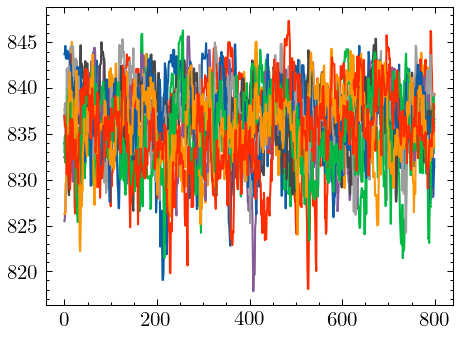

In [14]:
nb = 200
cutoff = 810

ii = np.where(np.min(lnp[nb:, :], axis=0) > cutoff)[0]

plt.plot(lnp[nb:, ii]);

In [15]:
design_chain = np.load('datfiles/fat_0.3_posterior_chain.npy')

def plot_chain_summary(ch, ax):
    low, med, high = np.quantile(ch, [0.16, 0.5, 0.84])
    ax.axhspan(low, high, color='C1', alpha=0.5)
    ax.axhline(med, color='C1')

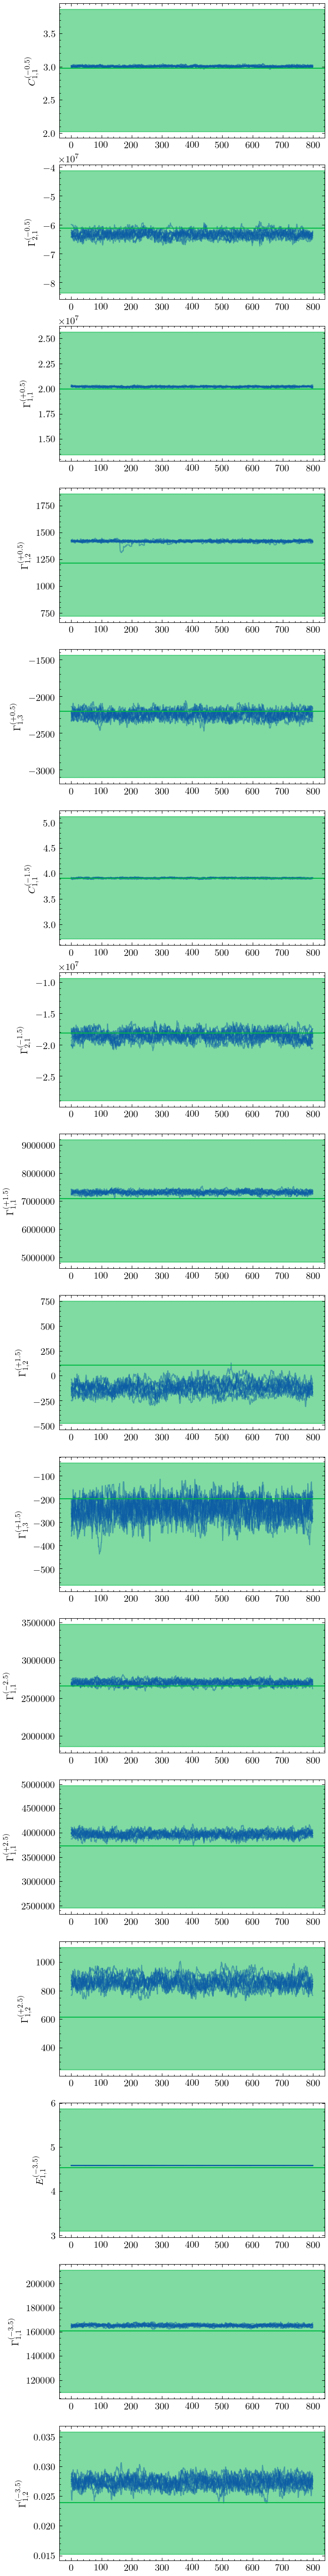

In [16]:
fig, ax = plt.subplots(model.nrpar, figsize=(gr*h, model.nrpar*h))
fig.patch.set_facecolor('white')

for i in range(model.nrpar):
    ax[i].plot(chain[nb:, ii, i], alpha=0.5, color='C0')
    ax[i].set_ylabel(model.azr.config.labels[i])
    plot_chain_summary(design_chain[:, i], ax[i])

In [17]:
# fig, ax = plt.subplots(model.nf_capture, 
#                        figsize=(gr*h, model.nf_capture*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar, model.nrpar + model.nf_capture)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [18]:
# fig, ax = plt.subplots(model.nf_scatter, 
#                        figsize=(gr*h, model.nf_scatter*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar + model.nf_capture, model.ndim)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [19]:
n1 = model.nbr
n2 = model.nxs

In [20]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [21]:
lnp[np.argmin(lnp)]

-1250.228018285004

In [22]:
lnp.shape

(64000,)

In [23]:
theta_bad = flat_chain[np.argmin(lnp), :]

In [24]:
np.argmin(lnp)

30

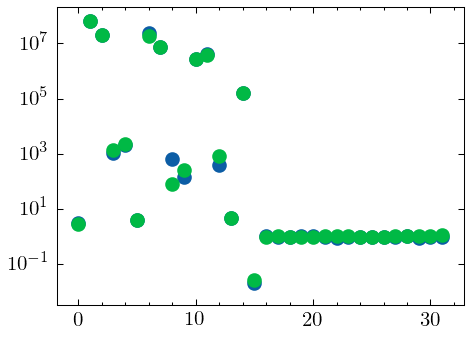

In [25]:
plt.scatter(np.arange(theta_bad.size), np.abs(theta_bad))
plt.scatter(np.arange(theta_star.size), np.abs(theta_star))
plt.yscale('log');

In [26]:
from bayes import ln_prior, Model2

In [27]:
m = Model2(emu)

In [28]:
m.ln_likelihood(theta_bad)

-1069.3991173762424

In [29]:
m.ln_likelihood(theta_star)

1026.1691496227063

In [30]:
print(f'{m.ln_likelihood(theta_bad, include_gp_var=False):.4e}')
print(f'{m.ln_likelihood(theta_star, include_gp_var=False):.4e}')

-1.7862e+04
1.2166e+03


In [31]:
from multiprocessing import Pool

In [32]:
with Pool(processes=16) as pool:
    lnpi = pool.map(ln_prior, flat_chain)

In [33]:
lnpi = np.array(lnpi)

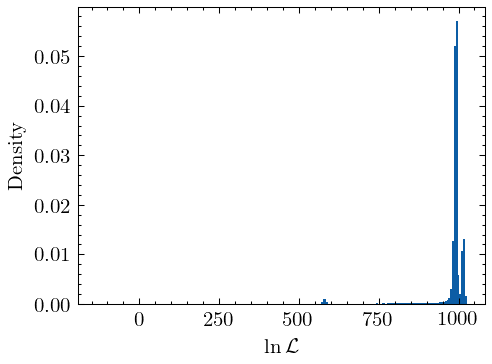

In [35]:
plt.hist(lnp[500:] - lnpi[500:],bins=200, density=True)
# plt.xlim([-1000, 750])
plt.xlabel('$\ln\mathcal{L}$')
plt.ylabel('Density');

In [36]:
mu_star = model.calculate_norm(theta_star)
mu_bad = model.calculate_norm(theta_bad)

In [37]:
def plot_prediction(theta, ax, start, stop, color='C2', label=None):
    p = emu.predict(theta=theta[:16])
    mu = p.mean().flatten()
    var = p.var().flatten()
    ax.errorbar(model.x[start:stop], mu[start:stop], yerr=np.sqrt(var[start:stop]),
                linestyle='', capsize=2, color=color, marker='x', alpha=0.5, label=label)

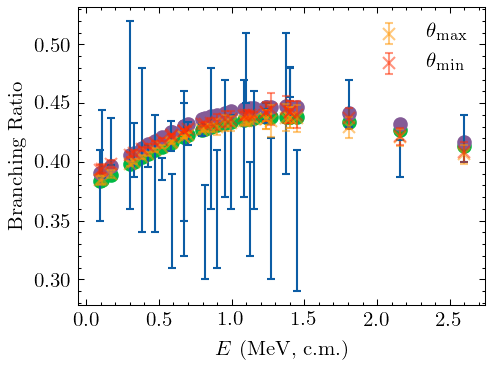

In [38]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[:n1], model.y[:n1], yerr=model.dy[:n1], linestyle='', capsize=2)
ax.scatter(model.x[:n1], mu_star[:n1], color='C1')
ax.scatter(model.x[:n1], mu_bad[:n1], color='C4')

plot_prediction(theta_star, ax, 0, n1, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, 0, n1, color='C3', label=r'$\theta_{\min}$')
# ax.errorbar(model.x[:n1], mu_star_gp[:n1], yerr=np.sqrt(mu_star_gp_var[:n1]), linestyle='', capsize=2, color='C2')

ax.legend()
ax.set_ylabel('Branching Ratio')
ax.set_xlabel('$E$ (MeV, c.m.)');

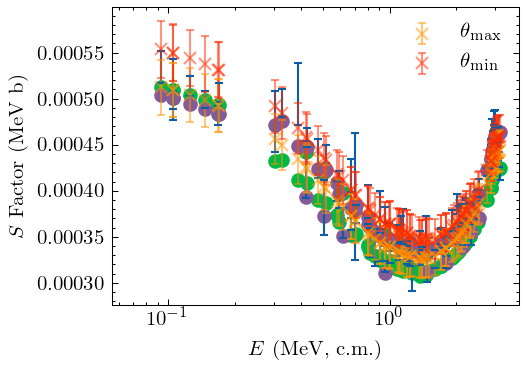

In [39]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], model.y[n1:n1+n2], yerr=model.dy[n1:n1+n2], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1, n1+n2, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1, n1+n2, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.x[n1:n1+n2], mu_star[n1:n1+n2], color='C1')
ax.scatter(model.x[n1:n1+n2], mu_bad[n1:n1+n2], color='C4')

# ax.scatter(model.x[n1:n1+n2], 1000*mu_star[n1:n1+n2], color='C1')
# ax.errorbar(model.x[n1:n1+n2], 1000*mu_star_gp[n1:n1+n2], yerr=1000*np.sqrt(mu_star_gp_var[n1:n1+n2]), linestyle='',
#             capsize=2, color='C2')

ax.legend()
ax.set_ylabel('$S$ Factor (MeV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_xscale('log');

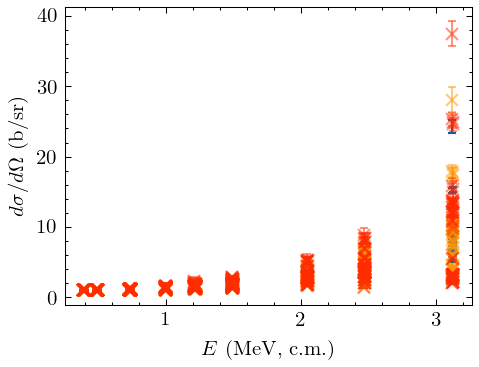

In [40]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1+n2:], model.y[n1+n2:], yerr=model.dy[n1+n2:], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1+n2, None, label=r'$\theta_{\max}$')
plot_prediction(theta_bad, ax, n1+n2, None, color='C3', label=r'$\theta_{\min}$')

# ax.scatter(model.x[n1+n2:], mu_star[n1+n2:], color='C1')
# ax.errorbar(model.x[n1+n2:], mu_star_gp[n1+n2:], yerr=np.sqrt(mu_star_gp_var[n1+n2:]), linestyle='',
#             capsize=2, color='C2')

ax.set_ylabel(r'$d\sigma/d\Omega$ (b/sr)')
ax.set_xlabel('$E$ (MeV, c.m.)');

In [41]:
b.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [21.23013263 17.31662831 23.23216911 11.03722805 35.12763863 16.12516663
 22.94757001 22.49790625 39.46186935 45.64532345 14.97369804 28.59003625
 47.06376807 13.12341798 22.17882802 18.03216047 14.04488228 17.0163105
 15.70987285 18.69862731 18.50227669 15.18401752 19.86833093 15.5887568
 15.78111477 15.76008918 14.65857483 13.59446911 12.60487852 17.73967411
 17.47253933 17.44625376]

In [42]:
from run import Run

In [43]:
import pickle

with open('/spare/odell/7Be/CP/samples/model_1_2021-08-06-02-55-37.pkl', 'rb') as f:
    run = pickle.load(f)

In [49]:
cs_flat_chain = run.get_flat_chain()

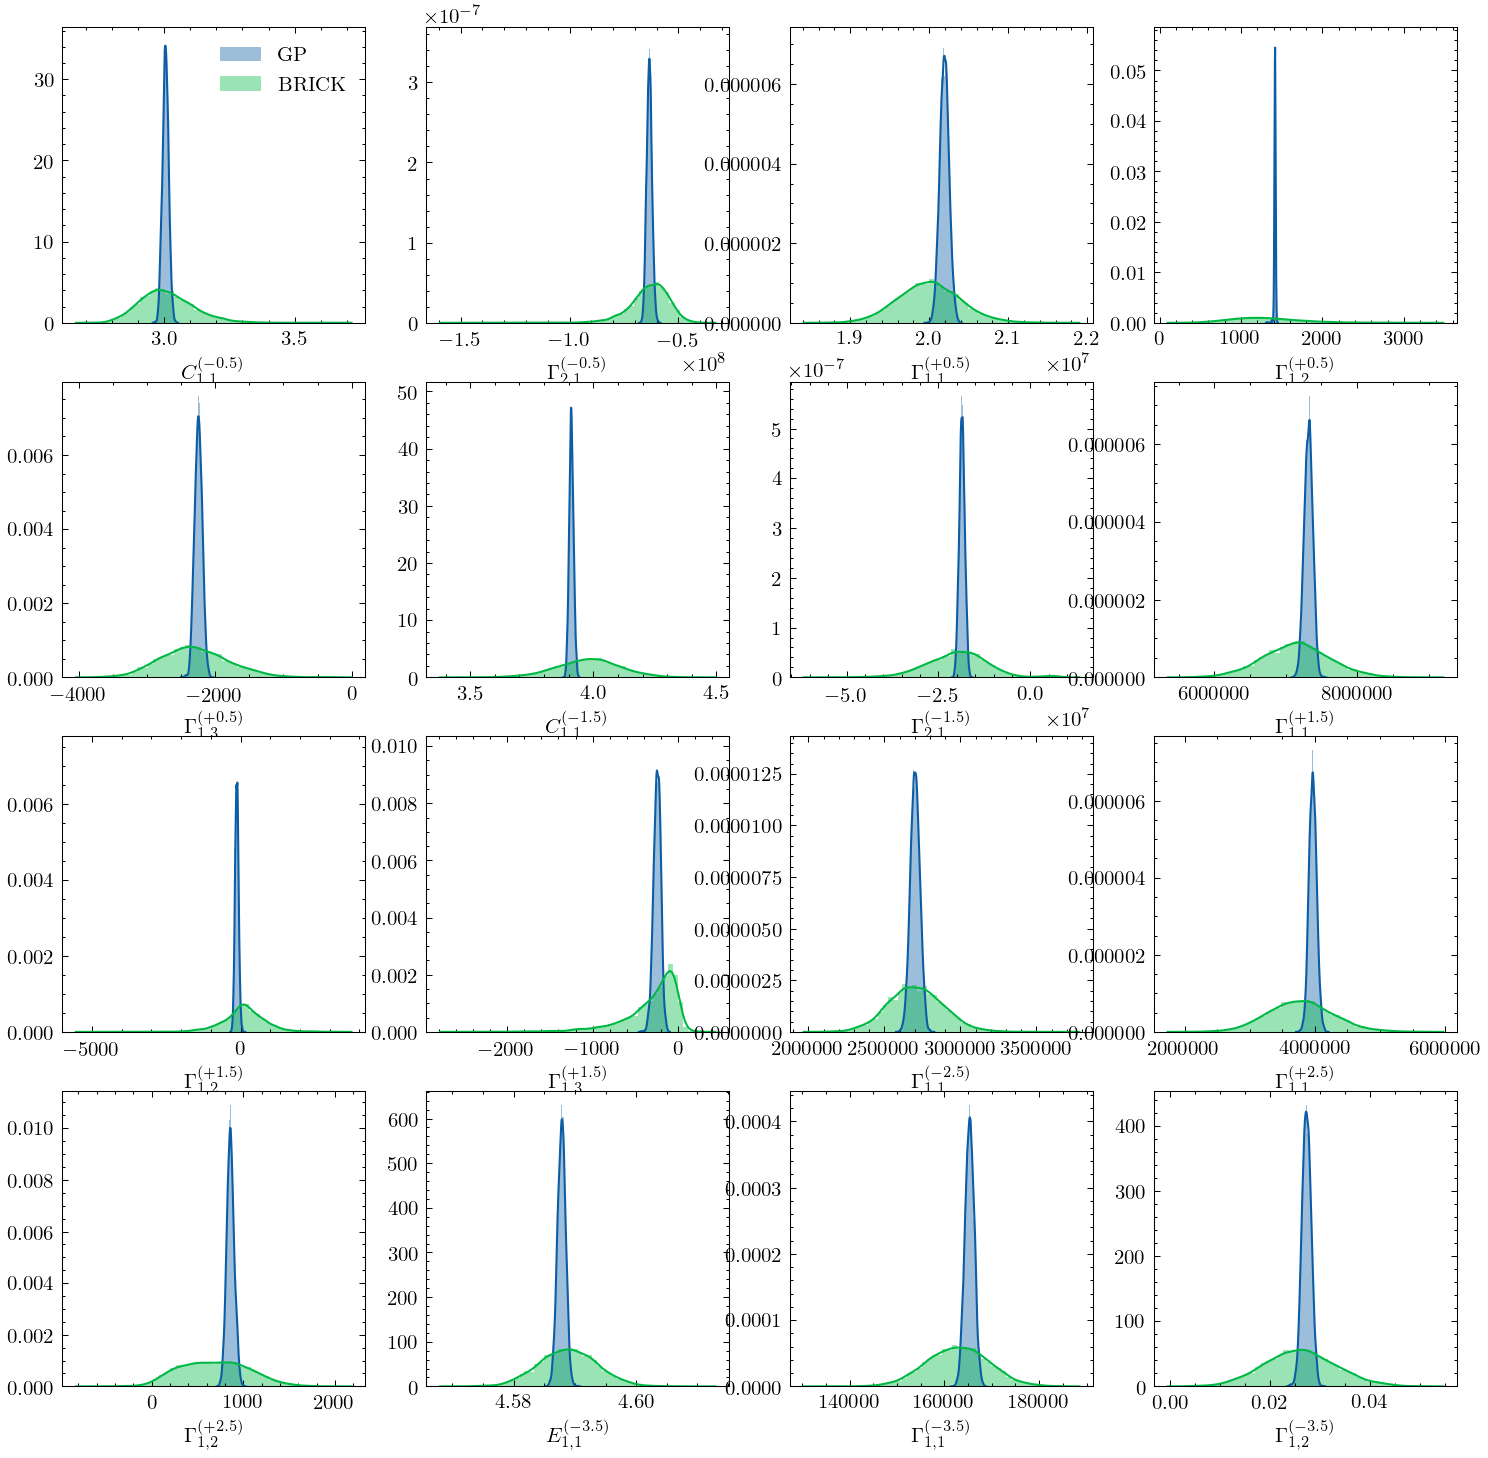

In [57]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = i*4 + j
        sns.distplot(chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel(model.azr.config.labels[k])
ax[0, 0].legend()

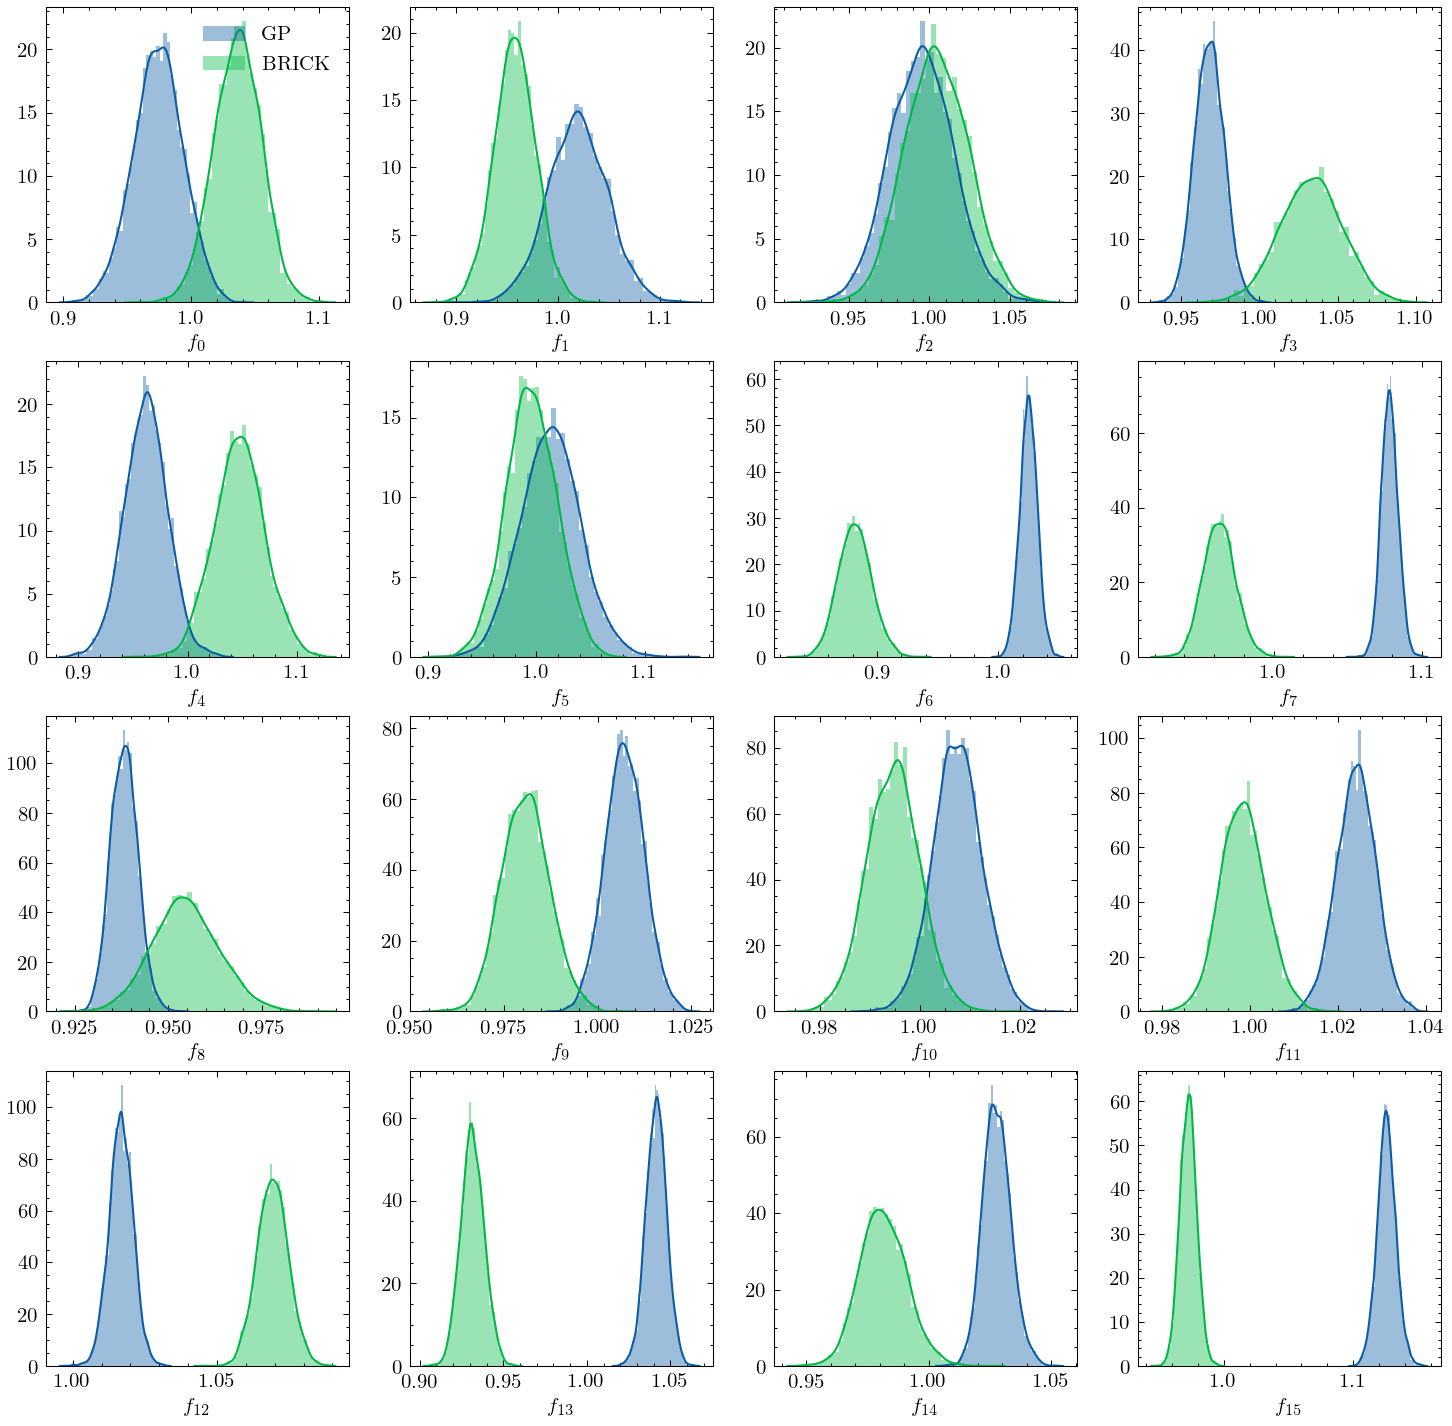

In [62]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = 16 + i*4 + j
        sns.distplot(chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel('$f_{%d}$' % (k-16))
ax[0, 0].legend()